In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .UnitTest
using .Geometry
using .Load
using .Misc
using Plots
using JSON

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [2]:
using Dates
using JLD
"""
    extract_datetime(SAFE_path; start_date=true)
    
    Extracts DateTime from a .SAFE file string. 

    # Arguments
    -`SAFE_path::String`: path to or name of .SAFE file
    -`start_date::Bool`: true for returning start date, false for end date.

    # Output
    - `::DateTime`: Date and time of .SAFE file

# Examples:
```jldoctest
julia> extract_datetime(S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE)
2017-03-09T05:40:35
```
"""
# SAFE_path can be path or SAFE file name, works either way.
function extract_datetime(SAFE_path; start_date=true, index=0)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    elseif index != 0
        date_string = split(extract_SAFE_name, "_")[index]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return Dates.value(Date(date1) - Date(date2))
end

"""
    number_of_SAFE_files(directory)
    
    Counts all .SAFE file names in directory

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `count::Int64`: Number of .SAFE files in directory

# Examples:
```jldoctest
julia> number_of_SAFE_files(/home/directory)
30
```
"""
# counts total number of SAFE files in directory
function number_of_SAFE_files(directory)
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                count += 1
            end
        end
    end
    return count
end

"""
    all_SAFE_files(directory)
    
    returns all .SAFE file names in directory as array

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `all_files::Array{String,N}`: Return .SAFE file names in Array. N is number of files

# Examples:
```jldoctest
julia> file_array = all_SAFE_files(/home/directory)
30-element Array{String,1}:
"S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
...
"S1B_IW_SLC__1SDV_20170830T053948_20170830T054014_007165_00CA0A_1DA1.SAFE"
```
"""
function all_SAFE_files(directory)
    all_files = Array{String, 1}(undef, number_of_SAFE_files(directory))
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                all_files[count + 1] = dir
                count += 1
            end
        end
    end
    return all_files
end

"""
    save_as_jld(data, file_name, file_path)

    saves input as .jld file

    # Arguments
    -`data::Any`: Saves input data
    -`file_name::String``: name of file without extension
    -`file_path::String``: path to directory

    # Output
    - None, saves file in file_path

# Examples:
```jldoctest
julia> save_as_jld(data, "data_file_name", "/home/user/result_folder")
```
"""
function save_as_jld(data, file_name, file_path)
    path = joinpath(file_path, file_name*".jld")
    JLD.save(path, "data", data)
end


function generate_id(product_folders, polarization)
    ID = Dict{String,String}()
    master_satellite = string(split(split(product_folders[1], "/")[end], "_")[1][end])
    slave_satellite = string(split(split(product_folders[2], "/")[end], "_")[1][end])

    # get last four digits in file name (identifier)
    master_safe_id = split(split(product_folders[1], "_")[end], ".")[1]
    slave_safe_id = split(split(product_folders[2], "_")[end], ".")[1]

    # compute days between acquisitions:
    master_date = replace.(string(Date(extract_datetime(product_folders[1]))),  "-" => "")
    slave_date = replace.(string(Date(extract_datetime(product_folders[2]))),  "-" => "")
    days_between_acq = string(abs(days_between_acquisitions(extract_datetime(product_folders[1]), extract_datetime(product_folders[2]))))*"d"

    # define id strings on format:            
    ID["master_id"] = "S1"*master_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id
    ID["slave_id"] = "S1"*slave_satellite*"_"*polarization*"_"*"S"*slave_date*"_"*slave_safe_id
    ID["coherence_id"] = master_satellite*slave_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id*"_"*"S"*slave_date*"_"*slave_safe_id*"_"*days_between_acq
    return ID
end


function sort_satellite_type(files, S1_selection)
    if S1_selection == "both"
        files = files[sortperm(extract_datetime.(files))]
    elseif S1_selection == "A"
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1A"]
        files = files[sortperm(extract_datetime.(files))]
    else
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1B"]
        files = files[sortperm(extract_datetime.(files))]
    end
    return files
end


function save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
    
    # make stride
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    if sum(save_string .== "coherence") != 0
        println("Saving complex coherence")
        complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]
        save_as_jld(complex_coherence, ID["coherence_id"]*"_coherence", result_folder)
    end   

    if sum(save_string .== "intensity") != 0
        println("Saving intensities")
        slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(slave_intensity, ID["slave_id"]*"_intensity", result_folder)
        master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(master_intensity, ID["master_id"]*"_intensity", result_folder)
    end

    # TODO: udvid save_as_jld() til at kunne tage flere inputs måske med ...
    if sum(save_string .== "auxillary") != 0
        println("Saving auxillary data")
        lines = lines[1:stride_line:end]
        samples = samples[1:stride_sample:end]

        # save lines and samples 
        line_sample_path = joinpath(result_folder,"line_sample.jld")
        JLD.save(line_sample_path, "lines", lines, "samples", samples)

        # Save heights
        heights = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
            reshape(lut["heights"],(length(lut["master_line"]),length(lut["master_sample"])))
            ,lines, samples);

        heights_path = joinpath(result_folder,"heights.jld")
        JLD.save(heights_path, "data", heights)
        
        lut_path = joinpath(result_folder, ID["master_id"]*"_lut.jld")  # consider identifying with m and s dates
        JLD.save(lut_path, "data", lut)
    end
end


┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1186


save_worker (generic function with 1 method)

In [4]:
pod_folder = "/Users/eyu/local_data/data/phase_bug/POD"
dem_path = "/Users/eyu/local_data/data/srtm_38_01/srtm_38_01_reprojected.tif"
dem_nan = 40
master_view = [2000:6000,1000:9000]
idx = [2, 1]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/Users/eyu/local_data/data/phase_bug/BB"
save_string = ["coherence", "intensity", "auxillary"]

sorted_files = [
    "S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE",
    "S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
]

directory = "/Users/eyu/local_data/data/phase_bug/BB"
sorted_files = joinpath.(directory, sorted_files)

product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
# ID = generate_id(product_folders, "VV")
ID = Dict{String,String}()
ID["master_id"] = "S1"*"B"*"_"*"VV"*"_"*"M"*"0408"
ID["slave_id"] = "S1"*"B"*"_"*"VV"*"_"*"S"*"0420"
ID["coherence_id"] = "B"*"B"*"_"*"VV"*"_"*"M"*"0408"*"_"*"S"*"0420"

println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

Processing:
Master: /Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE
Slave: /Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE
loading POD
loading DEM
Coregistering slave


proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
┌ Warning: `polyfit(x, y, n=length(x) - 1, sym=:x)` is deprecated, use `fit(Poly, x, y, n; var=sym)` instead.
│   caller = polyfit(::Array{Float64,1}, ::Array{Float64,1}, ::Int64) at deprecated.jl:56
└ @ Polynomials ./deprecated.jl:56
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


Mosaicking
Load master
Computing complex coherence


proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


TypeError: TypeError: non-boolean (typeof(save)) used in boolean context

In [5]:
save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))

Saving complex coherence
Saving intensities
Saving auxillary data


In [7]:
stride_line

UndefVarError: UndefVarError: stride_line not defined

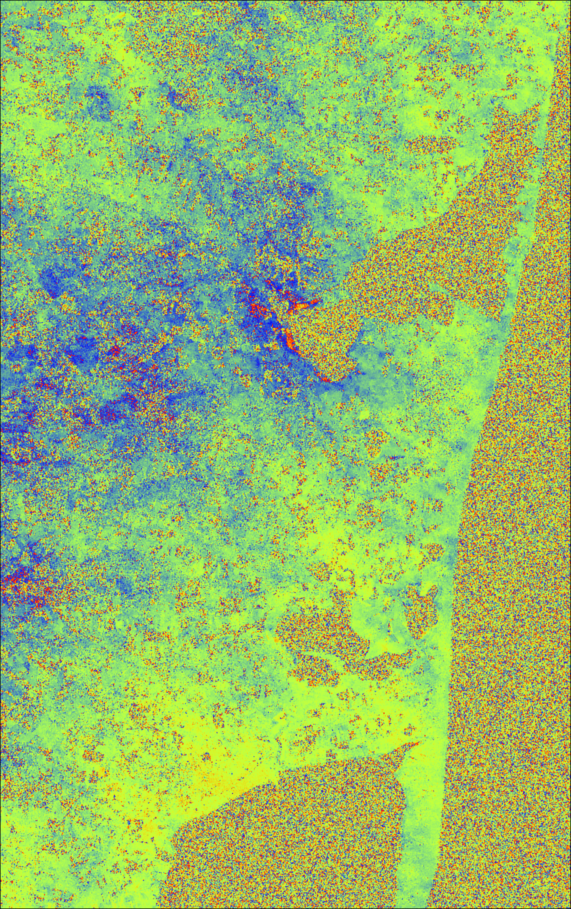

In [8]:
stride_line = floor(Int,size(kernel)[1]/2)
stride_sample = floor(Int,size(kernel)[2]/2)
phase_img = SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

In [2]:
# Should be function, but won't work inside module for some reason.
using JSON

path_to_gamma_json = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/srdem_subset.json"
srdem_subset = Dict()
open(path_to_gamma_json, "r") do f
    global srdem_subset
    dicttxt = read(f)  # file information to string
    srdem_subset = JSON.parse(String(dicttxt))  # parse and transform data
end
gamma_dem = Array{Float64}(undef, size(srdem_subset)..., size(srdem_subset[1])...)

for i in 1:length(srdem_subset)
    gamma_dem[i, :] = transpose(srdem_subset[i])
end

master_view = [1:size(gamma_dem)[1], 1:size(gamma_dem)[2]]

2-element Array{UnitRange{Int64},1}:
 1:4208
 1:1500

In [3]:
c = 299792458

master_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
slave_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"

m_data_path, m_meta_path, m_calibration_path = Load.slc_paths(master_safe_path, "VV", 3);
m_meta = Load.slc_meta(m_meta_path);
m_pod = Load.precise_orbit(Load.pod_path(m_meta["t_0"], m_meta["mission_id"],
                        "/Users/eyu/local_data/data/phase_bug/POD"), m_meta["t_0"])

s_data_path, s_meta_path, s_calibration_path = Load.slc_paths(slave_safe_path, "VV", 3);
s_meta = Load.slc_meta(s_meta_path);
s_pod = Load.precise_orbit(Load.pod_path(s_meta["t_0"], s_meta["mission_id"],
                        "/Users/eyu/local_data/data/phase_bug/POD"), s_meta["t_0"])

([-1.4083e6 1.48529e6 … 7185.33 -1890.54; -1.42336e6 1.55707e6 … 7170.5 -1966.68; … ; -2.05569e6 -5.69216e6 … 4185.16 6331.98; -2.05839e6 -5.64998e6 … 4249.14 6290.3], [-23958.0, -23948.0, -23938.0, -23928.0, -23918.0, -23908.0, -23898.0, -23888.0, -23878.0, -23868.0  …  69552.0, 69562.0, 69572.0, 69582.0, 69592.0, 69602.0, 69612.0, 69622.0, 69632.0, 69642.0])

In [5]:
# kør og byt de nedenstående ud med gamma
meta_paths = [m_meta_path, s_meta_path]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data;

In [6]:
meta[1]["t_start"] = 20394.149330 - UnitTest.seconds_since_midnight(m_meta["t_0"])
meta[1]["t_stop"] = 20402.797055 - UnitTest.seconds_since_midnight(m_meta["t_0"])
meta[1]["incidence_angle_mid"] = 43.5926
meta[1]["range_sampling_rate"] = 6.4345241e+07
meta[1]["azimuth_frequency"] = 486.4863103
meta[1]["slant_range_time"] = 902747.0461 * 2 / c;

meta[2]["t_0"] = s_meta["t_0"]
meta[2]["t_start"] = 20394.763347 - UnitTest.seconds_since_midnight(s_meta["t_0"])
meta[2]["t_stop"] = 20403.411072 - UnitTest.seconds_since_midnight(s_meta["t_0"])
meta[2]["right_looking"] = true
meta[2]["incidence_angle_mid"] = 43.5925
meta[2]["range_sampling_rate"] = 6.4345241e+07
meta[2]["azimuth_frequency"] = 486.4863103
meta[2]["slant_range_time"] = 902747.0461 * 2 / c;

In [8]:
pod_folder1 = "/Users/eyu/local_data/data/phase_bug/POD/S1B_OPER_AUX_POEORB_OPOD_20170428T111452_V20170407T225942_20170409T005942.EOF"
pod_folder2 = "/Users/eyu/local_data/data/phase_bug/POD/S1B_OPER_AUX_POEORB_OPOD_20170510T111443_V20170419T225942_20170421T005942.EOF"
pod_paths = [pod_folder1, pod_folder2]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(pod_paths)];

2-element Array{Tuple{Array{Float64,2},Array{Float64,1}},1}:
 ([-1.40915e6 1.48969e6 … 7184.44 -1895.2; -1.4242e6 1.56146e6 … 7169.56 -1971.33; … ; -2.05581e6 -5.68953e6 … 4189.19 6329.38; -2.0585e6 -5.64731e6 … 4253.15 6287.65], [-23958.0, -23948.0, -23938.0, -23928.0, -23918.0, -23908.0, -23898.0, -23888.0, -23878.0, -23868.0  …  69552.0, 69562.0, 69572.0, 69582.0, 69592.0, 69602.0, 69612.0, 69622.0, 69632.0, 69642.0])
 ([-1.4083e6 1.48529e6 … 7185.33 -1890.54; -1.42336e6 1.55707e6 … 7170.5 -1966.68; … ; -2.05569e6 -5.69216e6 … 4185.16 6331.98; -2.05839e6 -5.64998e6 … 4249.14 6290.3], [-23958.0, -23948.0, -23938.0, -23928.0, -23918.0, -23908.0, -23898.0, -23888.0, -23878.0, -23868.0  …  69552.0, 69562.0, 69572.0, 69582.0, 69592.0, 69602.0, 69612.0, 69622.0, 69632.0, 69642.0])

In [ ]:
# m_gamma_meta = Dict()
# m_gamma_meta["t_start"] = 20394.149330 - UnitTest.seconds_since_midnight(m_meta["t_0"])
# m_gamma_meta["t_stop"] = 20402.797055 - UnitTest.seconds_since_midnight(m_meta["t_0"])
# m_gamma_meta["right_looking"] = true
# m_gamma_meta["incidence_angle_mid"] = 43.5926
# m_gamma_meta["range_sampling_rate"] = 6.4345241e+07
# m_gamma_meta["azimuth_frequency"] = 486.4863103
# m_gamma_meta["slant_range_time"] = 902747.0461 * 2 / c;

m_state_vectors = m_pod[1]
m_time_state_vectors = m_pod[2];

In [ ]:
# s_gamma_meta = Dict()
# s_gamma_meta["t_0"] = s_meta["t_0"]
# s_gamma_meta["t_start"] = 20394.763347 - UnitTest.seconds_since_midnight(s_meta["t_0"])
# s_gamma_meta["t_stop"] = 20403.411072 - UnitTest.seconds_since_midnight(s_meta["t_0"])
# s_gamma_meta["right_looking"] = true
# s_gamma_meta["incidence_angle_mid"] = 43.5925
# s_gamma_meta["range_sampling_rate"] = 6.4345241e+07
# s_gamma_meta["azimuth_frequency"] = 486.4863103
# s_gamma_meta["slant_range_time"] = 902747.0461 * 2 / c;

s_state_vectors = s_pod[1] #s_state_vector_gamma 
s_time_state_vectors = s_pod[2] #time_state_vectors # gamma_time .- UnitTest.seconds_since_midnight(m_meta["t_0"]); # m_pod[2]

In [ ]:
#meta = [m_gamma_meta, s_gamma_meta]

In [ ]:
println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, s_data_path, meta, precise_orbit, dem);

In [ ]:
println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, s_data_path, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(s_data_path, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

In [ ]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
master_view = [2000:6000,1000:9000]
idx = [2, 1]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/Users/eyu/local_data/data/phase_bug/BB"
save_string = ["coherence", "intensity", "auxillary"]

sorted_files = [
    "S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE",
    "S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
]

directory = "/home/data/eigil/frame407_406"
sorted_files = joinpath.(directory, sorted_files)

product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
ID = generate_id(product_folders, "VV")

println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end